# CatBoost (GBDT) experiments.

Import dependencies.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

from preprocessors.preprocessor import Preprocessor

from preprocessors.scalers.min_max_scaler import MinMaxScalerData
from preprocessors.scalers.log_increases_scaler import LogIncreasesScalerData

from models.catboost.union_catboost import UnionCatBoost
from models.catboost.multi_catboost import MultiCatBoost, GreedyMultiCatBoost

from models.catboost.catboost_evaluator import Evaluator as CatBoostEvaluator

%matplotlib inline
%load_ext autoreload
%autoreload 2

If using Google Colab uncomment the cell below.

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
DATA_PATH = "../data/nasdaq100_padding.csv"
train_size = 30000
val_size = 5000
train_horizons = [7, 14]
prediction_horizons = [5, 10]
d_size = 5

In [4]:
df = pd.read_csv(DATA_PATH)

Let's try to use MinMaxScalerData to see, what happens.

In [5]:
scaler=MinMaxScalerData(train_size=30000)

preprocessor = Preprocessor(
    dataset=df.iloc[:40000, :].to_numpy(),
    max_pred_horizon=max(prediction_horizons),
    max_train_horizon=max(train_horizons),
    d_size=5,
)

Using cpu


In [6]:
preprocessor.train_val_test_split(
    train_size=train_size,
    val_size=val_size,
    scaler=scaler,
    use_tqdm=True,
)

100%|██████████| 4975/4975 [00:00<00:00, 6204.68it/s] 


Check the plot for each row.

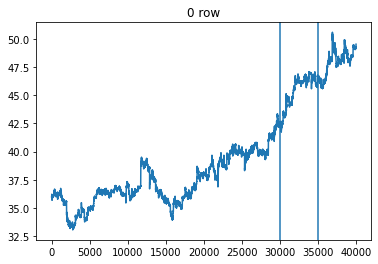

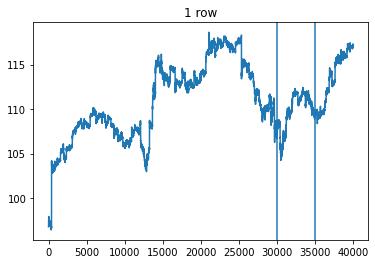

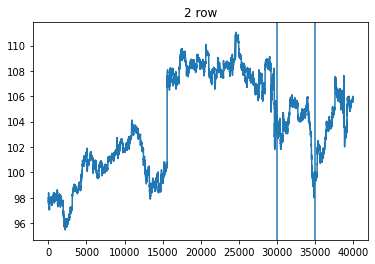

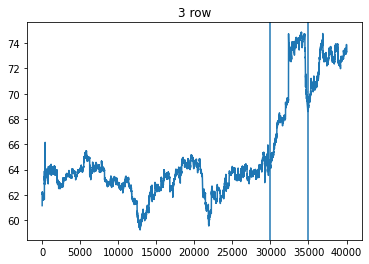

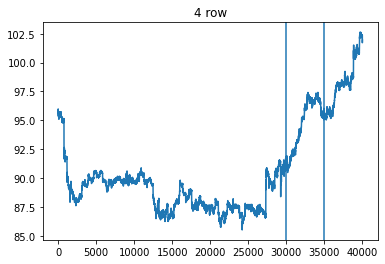

In [7]:
for row_ind in range(d_size):
    preprocessor.plot_row(row=row_ind)

As we can see, there is no point to predict for 0, 3 and 4 rows because the range of values in validation and test part significantly differes from the train part.

Let's try to predict mean for row with index 1 on values of rows 1-2.

In [8]:
mae_union_catboost_eval = CatBoostEvaluator(
    regressor=UnionCatBoost,
    preprocessor=preprocessor,
    function_x=lambda x: x[:, :, 1],
    function_y=lambda y: y[:, :, 1].mean(axis=-1),
    train_horizons=train_horizons,
    prediction_horizons=prediction_horizons,
    metric=mean_absolute_error,
    metric_name='MAE',
    loss_function='MAE',
    grid_search_params={
        'verbose': [500],
        'has_time': [True],
        'depth': [8],
    },
    use_gpu=False,
)

In [9]:
mae_union_catboost_eval.evaluate_params()

Train_horizon: 7
Prediction_horizon: 5
Estimator params: {'verbose': 500, 'has_time': True, 'depth': 8}
0:	learn: 0.1643870	test: 0.0669642	best: 0.0669642 (0)	total: 66.6ms	remaining: 1m 6s
500:	learn: 0.0034302	test: 0.0040551	best: 0.0040551 (498)	total: 3.95s	remaining: 3.93s
999:	learn: 0.0030070	test: 0.0037917	best: 0.0037917 (999)	total: 7.85s	remaining: 0us

bestTest = 0.003791732585
bestIteration = 999

Best shift: 5
Best estimator params: {'verbose': 500, 'has_time': True, 'depth': 8}
Train_horizon: 7
Prediction_horizon: 10
Estimator params: {'verbose': 500, 'has_time': True, 'depth': 8}
0:	learn: 0.1643452	test: 0.0669274	best: 0.0669274 (0)	total: 8.72ms	remaining: 8.71s
500:	learn: 0.0041657	test: 0.0049869	best: 0.0049869 (500)	total: 2.76s	remaining: 2.75s
999:	learn: 0.0037422	test: 0.0048283	best: 0.0048283 (999)	total: 6.77s	remaining: 0us

bestTest = 0.004828284667
bestIteration = 999

Best shift: 8
Best estimator params: {'verbose': 500, 'has_time': True, 'depth': 

In [10]:
mae_union_catboost_eval.form_table()

Metric: MAE
Loss function: MAE
          7         14
5   0.001503  0.001687
10  0.002019  0.001989


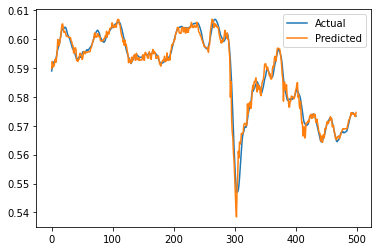

In [11]:
mae_union_catboost_eval.plot_union(
    train_horizon=14,
    pred_horizon=10,
    start_ind=35000,
    end_ind=35500,
)


Using the same method min/max/value on n-th day from the current can be predicted.

Let's try to deal with multi-target output.

Let's initially use MultiRMSE - the only loss-function, supported for honest multi-target output in GBDT.

In [12]:
mae_multi_catboost_eval = CatBoostEvaluator(
    regressor=MultiCatBoost,
    preprocessor=preprocessor,
    function_x=lambda x: x[:, :, 1],
    function_y=lambda y: y[:, :, 1],
    train_horizons=train_horizons,
    prediction_horizons=prediction_horizons,
    metric=mean_absolute_error,
    metric_name='MAE',
    loss_function='MultiRMSE',
    grid_search_params={
        'verbose': [500],
        'has_time': [True],
        'depth': [8]
    },
    use_gpu=False,
)

In [13]:
mae_multi_catboost_eval.evaluate_params()

Train_horizon: 7
Prediction_horizon: 5
Estimator params: {'verbose': 500, 'has_time': True, 'depth': 8}
0:	learn: 1.4617286	test: 1.3256556	best: 1.3256556 (0)	total: 61ms	remaining: 1m
500:	learn: 0.0183560	test: 0.0155100	best: 0.0155098 (496)	total: 16s	remaining: 16s
999:	learn: 0.0174774	test: 0.0148614	best: 0.0148614 (999)	total: 32.5s	remaining: 0us

bestTest = 0.01486136981
bestIteration = 999

Best shift: 5
Best estimator params: {'verbose': 500, 'has_time': True, 'depth': 8}
Train_horizon: 7
Prediction_horizon: 10
Estimator params: {'verbose': 500, 'has_time': True, 'depth': 8}
0:	learn: 2.0672461	test: 1.8748837	best: 1.8748837 (0)	total: 82.1ms	remaining: 1m 21s
500:	learn: 0.0313818	test: 0.0271436	best: 0.0271431 (492)	total: 33.3s	remaining: 33.2s
999:	learn: 0.0301958	test: 0.0263079	best: 0.0263079 (999)	total: 1m 6s	remaining: 0us

bestTest = 0.02630790997
bestIteration = 999

Best shift: 8
Best estimator params: {'verbose': 500, 'has_time': True, 'depth': 8}
Train_h

In [14]:
mae_multi_catboost_eval.form_table()

Metric: MAE
Loss function: MultiRMSE
          7         14
5   0.002511  0.003071
10  0.002728  0.003081


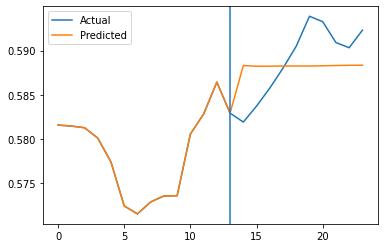

In [15]:
mae_multi_catboost_eval.plot_multi(
    train_horizon=14,
    pred_horizon=10,
    start_ind=35000,
)

Well, not everything that bad:)

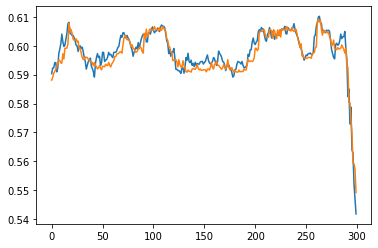

In [16]:
plt.plot(preprocessor.y_test[:, 8, 1][:300])
plt.plot(mae_multi_catboost_eval.best_model[14][10].predict(preprocessor.x_test[12:, -14:, 1])[:, 8][0:300])

Let's try GreedyMultiCatBoost.

In [17]:
mae_greedy_catboost_eval = CatBoostEvaluator(
    regressor=GreedyMultiCatBoost,
    preprocessor=preprocessor,
    function_x=lambda x: x[:, :, 1],
    function_y=lambda y: y[:, :, 1],
    train_horizons=train_horizons,
    prediction_horizons=prediction_horizons,
    metric=mean_absolute_error,
    metric_name='MAE',
    loss_function='MAE',
    grid_search_params={
        'silent': [True],
        'has_time': [True],
        'depth': [8]
    },
    use_gpu=False,
)

In [18]:
mae_greedy_catboost_eval.evaluate_params()

Train_horizon: 7
Prediction_horizon: 5
Estimator params: {'silent': True, 'has_time': True, 'depth': 8}
Best shift: 5
Best estimator params: {'silent': True, 'has_time': True, 'depth': 8}
Train_horizon: 7
Prediction_horizon: 10
Estimator params: {'silent': True, 'has_time': True, 'depth': 8}
Best shift: 8
Best estimator params: {'silent': True, 'has_time': True, 'depth': 8}
Train_horizon: 14
Prediction_horizon: 5
Estimator params: {'silent': True, 'has_time': True, 'depth': 8}
Best shift: 5
Best estimator params: {'silent': True, 'has_time': True, 'depth': 8}
Train_horizon: 14
Prediction_horizon: 10
Estimator params: {'silent': True, 'has_time': True, 'depth': 8}
Best shift: 9
Best estimator params: {'silent': True, 'has_time': True, 'depth': 8}


In [19]:
mae_greedy_catboost_eval.form_table()

Metric: MAE
Loss function: MAE
          7         14
5   0.002529  0.003161
10  0.002843  0.003369


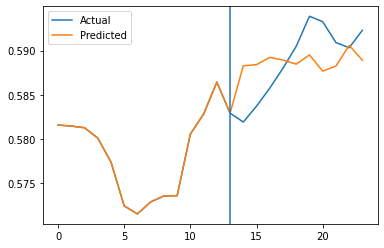

In [20]:
mae_greedy_catboost_eval.plot_multi(
    train_horizon=14,
    pred_horizon=10,
    start_ind=35000,
)